# ExcelFormer with the RNN
The notebook contains the pipeline to train and validate the model (+ training the final version of the model on the full data)

In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score, f1_score, recall_score, precision_score, matthews_corrcoef

from model.rnn import GRUDecoder
from model.encoders import CustomExcelFormer
from data_processing.pipeline import encoding_pipeline, get_generic_name


import matplotlib.pyplot as plt
from model.utils import get_device
from model.dataset import PretrainingDataset
from model.dataset import FinetuningDataset


In [2]:
def bootstrap(preds, targs, metric, n_bootstraps: int):
    """
    Returns mean and 95% Confidentence intervals for a metric
    """
    results = []
    for _ in range(n_bootstraps):
        idx = np.random.choice(preds.shape[0], size=preds.shape[0], replace=True)
        results.append(metric(targs[idx], preds[idx]))

    return {"mean": np.mean(results),
            "CIs": np.quantile(results,q=np.array([0.025, 0.975]))}

In [3]:
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [4]:
class DataClass:
    def __init__(self,
                 data_path: str = "data/training_data/PreFer_train_data.csv",
                 targets_path: str = 'data/training_data/PreFer_train_outcome.csv',
                 codebook_path: str = 'data/codebooks/PreFer_codebook.csv',
                 importance_path: str = 'features_importance_all.csv') -> None:
        self.data = pd.read_csv(data_path, low_memory=False)
        self.targets = pd.read_csv(targets_path)
        self.codebook = pd.read_csv(codebook_path)
        self.col_importance = pd.read_csv(importance_path)
    def make_sequences(self, n_cols: int, use_codebook: bool = True):
        custom_pairs = self.col_importance.feature.map(lambda x: get_generic_name(x)).unique()[:n_cols]
        self.sequences = encoding_pipeline(self.data, self.codebook, 
                                           custom_pairs=custom_pairs, 
                                           importance=self.col_importance, 
                                           use_codebook=use_codebook)
    def make_pretraining(self):
        self.pretrain_dataset = PretrainingDataset(self.sequences)
        self.seq_len = self.pretrain_dataset.get_seq_len()
        self.vocab_size = self.pretrain_dataset.get_vocab_size()
    def make_full_finetuning(self, batch_size): 
        """Create dataloader for the whole finetuning dataset"""
        targets = self.targets[self.targets.new_child.notna()]
        full_person_ids =  targets['nomem_encr'].values
        rnn_data = {person_id: (
                torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
                torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
                )
                for person_id, wave_responses in self.sequences.items()
                }

        # split data based on the splits made for the target
        full_data = {person_id: rnn_data[person_id] for person_id in full_person_ids}
        self.full_dataset = FinetuningDataset(full_data, targets = targets)
        self.full_dataloader = DataLoader(self.full_dataset, batch_size=batch_size, shuffle=True)


    def make_finetuning(self, batch_size, test_size: float = 0.2, val_size: float = 0.2):
        """
        Create dataloaders for the train/val/test splits.
        """
        targets = self.targets[self.targets.new_child.notna()]
        train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=test_size, random_state=42)
        train_person_ids, val_person_ids = train_test_split(train_person_ids, test_size=val_size, random_state=42)
        rnn_data = {person_id: (
                torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
                torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
                )
                for person_id, wave_responses in self.sequences.items()
                }

        # split data based on the splits made for the target
        train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
        val_data = {person_id: rnn_data[person_id] for person_id in val_person_ids}
        test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

        self.train_dataset = FinetuningDataset(train_data, targets = targets)
        self.val_dataset = FinetuningDataset(val_data, targets = targets)
        self.test_dataset = FinetuningDataset(test_data, targets = targets)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False)
        self.test_dataloader  = DataLoader(self.test_dataset,  batch_size=batch_size)


In [5]:
# LOAD THE DATA
data = DataClass()

In [6]:
# GLOBAL VARIABLES
BATCH_SIZE = 16
HIDDEN_SIZE =  48
ENCODING_SIZE = 48
NUM_HEADS = 4
NUM_LAYERS = 5
NUM_EPOCHS = 12
DETECT_ANOMALY = False
LR = 1e-2

assert HIDDEN_SIZE % NUM_HEADS == 0, "Check that the hidden size is divisible"


In [7]:
data.make_sequences(n_cols=150)
data.make_pretraining()
data.make_finetuning(batch_size=BATCH_SIZE)
data.make_full_finetuning(batch_size=BATCH_SIZE)
print("Done!")

/Users/carlomarx/Documents/GitHub/fertility-prediction-challenge/data_processing/pipeline.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


Done!


In [8]:
SEQ_LEN = data.seq_len
VOCAB_SIZE = data.vocab_size
print(SEQ_LEN)

149


# Model and Training Setup
Here we setup the model and training procedures 

In [9]:
class PreFerPredictor(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = CustomExcelFormer(vocab_size=VOCAB_SIZE, 
                            hidden_size=HIDDEN_SIZE, 
                            out_size=ENCODING_SIZE,
                            n_years=14,
                            num_heads=NUM_HEADS,
                            num_layers=NUM_LAYERS, 
                            sequence_len=SEQ_LEN, 
                            aium_dropout=0.3,
                            diam_dropout=0.1,
                            residual_dropout=0.1,
                            embedding_dropout=0.25).to(device)
        self.decoder = GRUDecoder(
            input_size=ENCODING_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=2,
            max_seq_len=14,
            dropout=0.25,
  
            bidirectional=True,
            with_attention = True
        ).to(device)

        self.enc_dropout = nn.Dropout(0.1)
        self.enc_dropout1d = nn.Dropout1d(0.1)
    def forward(self, input_year, input_seq, labels):
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings, _ = self.encoder(input_year, input_seq)#, y=labels.unsqueeze(-1).expand(-1, 14).reshape(-1), mixup_encoded=True)
        encodings = encodings.view(bs,ss, -1)
        encodings = self.enc_dropout(encodings)
        encodings = self.enc_dropout1d(encodings)
        mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()
        # Forward pass
        out = self.decoder(encodings, mask=mask).flatten()
        return out


In [21]:
model = PreFerPredictor().to(device)
# Define the loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/0.2]).to(device))

# Define the optimization strategy
optimizer = torch.optim.RAdam(model.parameters() , lr=LR, weight_decay=1e-2, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = NUM_EPOCHS * len(data.train_dataloader), eta_min = 8e-4, last_epoch = -1)
## EMA Weight Averaging
avg_fn = optim.swa_utils.get_ema_avg_fn(0.99)
avg_model = optim.swa_utils.AveragedModel(model, avg_fn=avg_fn, use_buffers=False)
avg_start = 3

# Training loop
model.train()
avg_model.train()
print("Ready!")

Ready!


In [22]:
def run_validation(epoch):
    """
    Run the validation loop
    """
    val_loss = []
    preds = []
    targets = []

    model.eval()
    avg_model.eval()
    for batch in data.val_dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)
        input_year, input_seq = inputs
        if epoch <= avg_start:
            output = model(input_year=input_year, input_seq=input_seq, labels=labels)
        else:
            output = avg_model(input_year=input_year, input_seq=input_seq, labels=labels)

        probs = F.sigmoid(output).flatten()
        loss = loss_fn(output, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(probs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())

    # Concatenate all the batches
    yhat = torch.tensor(preds).flatten().detach().cpu().numpy()
    ytrue = torch.tensor(targets).flatten().cpu().numpy()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(ytrue, yhat > 0.5, average='binary')
    mcc = matthews_corrcoef(ytrue, yhat > 0.5)
    map_roc = average_precision_score(ytrue, yhat)
    print(f"-- mAP Score: {map_roc:.4f} -- f1-score: {f1:.3f} -- mcc: {mcc:.3f}")
    model.train()
    avg_model.train()

In [23]:
loss_per_epoch = []
for epoch in range(NUM_EPOCHS):
    loss_per_step = []
    loop_object  = tqdm(enumerate(data.train_dataloader), desc=f"Epochs {epoch}")
    for i, batch in loop_object :        
        optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)
        input_year, input_seq = inputs
        ### Model
        output = model(input_year=input_year, input_seq=input_seq, labels=labels)
        probs = F.sigmoid(output).flatten()
        ### Loss
        loss = loss_fn(output, labels) #+ loss_focal(output, labels)
        loss_per_step.append(loss.detach().cpu().numpy())
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))
        loss.backward()
        optimizer.step()
        scheduler.step()

    # AVERAGING starts only after 3 epochs
        if epoch > avg_start:
            avg_model.update_parameters(model)
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    scheduler.step()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss_per_epoch[-1]:.4f}")
    run_validation(epoch=epoch)
    

Epochs 0: 40it [00:11,  3.59it/s, mean loss: 3.005]


Epoch 1/12, Loss: 3.0054


/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-- mAP Score: 0.3946 -- f1-score: 0.000 -- mcc: 0.000


Epochs 1: 40it [00:11,  3.61it/s, mean loss: 2.521]


Epoch 2/12, Loss: 2.5211
-- mAP Score: 0.5830 -- f1-score: 0.488 -- mcc: 0.298


Epochs 2: 40it [00:11,  3.63it/s, mean loss: 2.034]


Epoch 3/12, Loss: 2.0345
-- mAP Score: 0.7151 -- f1-score: 0.609 -- mcc: 0.519


Epochs 3: 40it [00:10,  3.64it/s, mean loss: 1.260]


Epoch 4/12, Loss: 1.2595
-- mAP Score: 0.7589 -- f1-score: 0.567 -- mcc: 0.536


Epochs 4: 40it [00:12,  3.15it/s, mean loss: 1.065]


Epoch 5/12, Loss: 1.0653
-- mAP Score: 0.7691 -- f1-score: 0.590 -- mcc: 0.556


Epochs 5: 40it [00:12,  3.16it/s, mean loss: 0.950]


Epoch 6/12, Loss: 0.9497
-- mAP Score: 0.7768 -- f1-score: 0.625 -- mcc: 0.574


Epochs 6: 40it [00:12,  3.20it/s, mean loss: 0.750]


Epoch 7/12, Loss: 0.7499
-- mAP Score: 0.7814 -- f1-score: 0.676 -- mcc: 0.613


Epochs 7: 40it [00:12,  3.22it/s, mean loss: 0.590]


Epoch 8/12, Loss: 0.5899
-- mAP Score: 0.7697 -- f1-score: 0.686 -- mcc: 0.614


Epochs 8: 40it [00:12,  3.22it/s, mean loss: 0.419]


Epoch 9/12, Loss: 0.4186
-- mAP Score: 0.7549 -- f1-score: 0.722 -- mcc: 0.653


Epochs 9: 40it [00:12,  3.22it/s, mean loss: 0.259]


Epoch 10/12, Loss: 0.2587
-- mAP Score: 0.7379 -- f1-score: 0.722 -- mcc: 0.653


Epochs 10: 40it [00:12,  3.21it/s, mean loss: 0.268]


Epoch 11/12, Loss: 0.2684
-- mAP Score: 0.7299 -- f1-score: 0.732 -- mcc: 0.671


Epochs 11: 40it [00:12,  3.22it/s, mean loss: 0.242]


Epoch 12/12, Loss: 0.2421
-- mAP Score: 0.7239 -- f1-score: 0.732 -- mcc: 0.671


In [66]:
test_loss = []
preds = []
targets = []

## Set both models into the eval mode.=
avg_model.eval()
for batch in data.test_dataloader:
    inputs, labels = batch
    labels = labels.to(torch.float).to(device)
    input_year, input_seq = inputs
    ### Model
    output = avg_model(input_year=input_year, input_seq=input_seq, labels=labels)
    probs = F.sigmoid(output).flatten()

    loss = loss_fn(output, labels)  
    test_loss.append(loss.detach().cpu().numpy())
    preds.extend(probs.detach().cpu().numpy().tolist())
    targets.extend(labels.cpu().numpy().tolist())

# Concatenate all the batches
probs = torch.tensor(preds).flatten()
actuals = torch.tensor(targets).flatten()
# Concatenate all the batches

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), probs.cpu().numpy() > 0.5, average='binary')
map_roc = average_precision_score(actuals.numpy(), probs.numpy())
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"-- mAP Score: {map_roc:.4f} --")

Precision: 0.7660
Recall: 0.7200
F1 Score: 0.7423
-- mAP Score: 0.8419 --


(array([98., 24., 15.,  9.,  5.,  5.,  6.,  5., 15., 16.]),
 array([0.00353061, 0.10084035, 0.1981501 , 0.29545984, 0.3927696 ,
        0.49007934, 0.58738911, 0.68469882, 0.78200859, 0.8793183 ,
        0.97662807]),
 <BarContainer object of 10 artists>)

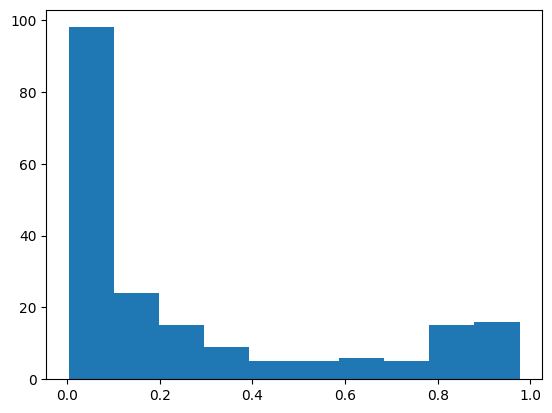

In [67]:
plt.hist(probs)

In [68]:
print("Estimated Performance of the Model:")
print("\tF1 Score:", bootstrap( probs.cpu().numpy() > 0.5, actuals.cpu().numpy(), metric= lambda x,y: f1_score(x,y), n_bootstraps=10000))
print("\tMCC Score:", bootstrap( probs.cpu().numpy() > 0.5, actuals.cpu().numpy(), metric= lambda x,y: matthews_corrcoef(x,y), n_bootstraps=10000))
print("\tPrecision:", bootstrap( probs.cpu().numpy() > 0.5, actuals.cpu().numpy(), metric= lambda x,y: precision_score(x,y), n_bootstraps=10000))
print("\tRecall:", bootstrap( probs.cpu().numpy() > 0.5, actuals.cpu().numpy(), metric= lambda x,y: recall_score(x,y), n_bootstraps=10000))
print("\tmAP Score:", bootstrap(preds = probs.cpu().numpy(), targs =  actuals.cpu().numpy(), metric= lambda x,y: average_precision_score(x,y), n_bootstraps=10000))

Estimated Performance of the Model:
	F1 Score: {'mean': 0.739795146914729, 'CIs': array([0.63529412, 0.83168317])}
	MCC Score: {'mean': 0.6585547581908553, 'CIs': array([0.5325456 , 0.77700526])}
	Precision: {'mean': 0.7652470989493324, 'CIs': array([0.63829787, 0.88372093])}
	Recall: {'mean': 0.719310777388724, 'CIs': array([0.59090909, 0.83673469])}
	mAP Score: {'mean': 0.8422834497648027, 'CIs': array([0.75197675, 0.91293439])}


# Train Model on the Full Data
(model for inference)

In [17]:
# Reinitialize the training 
model = PreFerPredictor().to(device)
# Define the loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/0.2]).to(device))
# Define the optimization strategy
optimizer = torch.optim.RAdam(model.parameters() , lr=LR, weight_decay=1e-2, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = NUM_EPOCHS * len(data.full_dataloader), eta_min = 5e-4, last_epoch = -1)
## EMA Weight Averaging
avg_fn = optim.swa_utils.get_ema_avg_fn(0.99)
avg_model = optim.swa_utils.AveragedModel(model, avg_fn=avg_fn, use_buffers=False)
avg_start = 3

# Training loop
model.train()
avg_model.train()
print("Ready!")

/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ready!


In [18]:
## TRAIN ON THE FULL DATA
loss_per_epoch = []
for epoch in range(NUM_EPOCHS):
    loss_per_step = []
    loop_object  = tqdm(enumerate(data.full_dataloader), desc=f"Epochs {epoch}")
    for i, batch in loop_object :        
        optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)
        input_year, input_seq = inputs
        ### Model
        output = model(input_year=input_year, input_seq=input_seq, labels=labels)
        probs = F.sigmoid(output).flatten()
        ### Loss
        loss = loss_fn(output, labels)  
        loss_per_step.append(loss.detach().cpu().numpy())
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))
        loss.backward()
        optimizer.step()
        scheduler.step()

    # AVERAGING starts only after 3 epochs
        if epoch > avg_start:
            avg_model.update_parameters(model)
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    scheduler.step()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss_per_epoch[-1]:.4f}")
    #run_validation(epoch=epoch)

Epochs 0: 62it [00:18,  3.43it/s, mean loss: 1.242]


Epoch 1/12, Loss: 1.2419


Epochs 1: 62it [00:17,  3.61it/s, mean loss: 0.846]


Epoch 2/12, Loss: 0.8462


Epochs 2: 62it [00:17,  3.59it/s, mean loss: 0.617]


Epoch 3/12, Loss: 0.6166


Epochs 3: 62it [00:17,  3.63it/s, mean loss: 0.517]


Epoch 4/12, Loss: 0.5165


Epochs 4: 62it [00:19,  3.17it/s, mean loss: 0.514]


Epoch 5/12, Loss: 0.5141


Epochs 5: 62it [00:19,  3.14it/s, mean loss: 0.382]


Epoch 6/12, Loss: 0.3821


Epochs 6: 62it [00:19,  3.17it/s, mean loss: 0.258]


Epoch 7/12, Loss: 0.2580


Epochs 7: 62it [00:19,  3.16it/s, mean loss: 0.206]


Epoch 8/12, Loss: 0.2062


Epochs 8: 62it [00:19,  3.14it/s, mean loss: 0.128]


Epoch 9/12, Loss: 0.1280


Epochs 9: 62it [00:19,  3.14it/s, mean loss: 0.102]


Epoch 10/12, Loss: 0.1019


Epochs 10: 62it [00:19,  3.12it/s, mean loss: 0.080]


Epoch 11/12, Loss: 0.0796


Epochs 11: 62it [00:19,  3.19it/s, mean loss: 0.076]

Epoch 12/12, Loss: 0.0756


In [21]:
SAVE_PATH = "weights/excel_rnn.pt"
torch.save(avg_model.state_dict(), SAVE_PATH)

In [22]:
from model.full_model import PreFerPredictor
import torch

In [24]:
model = optim.swa_utils.AveragedModel(PreFerPredictor())
model.load_state_dict(torch.load("weights/excel_rnn.pt"))

<All keys matched successfully>

# Check if the loading pipeline works

In [1]:
from model.full_model import DataClass, PreFerPredictor
import torch
import pandas as pd
from model.utils import get_device


Using MPS (Metal Performance Shaders) device


In [2]:
data = DataClass(to_predict_df=pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False).sample(frac=0.2))


In [3]:
data.make_sequences(n_cols=150)
data.prepare_prediction(batch_size=16) 

/Users/carlomarx/Documents/GitHub/fertility-prediction-challenge/data_processing/pipeline.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)
/Users/carlomarx/Documents/GitHub/fertility-prediction-challenge/data_processing/pipeline.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(101)


In [4]:
device = get_device()

Using MPS (Metal Performance Shaders) device


In [5]:
model = torch.optim.swa_utils.AveragedModel(PreFerPredictor())
model.load_state_dict(torch.load("weights/excel_rnn.pt", map_location=device))
predictions = model.get_submodule("module").predict(data.prediction_dataloader, device)

In [6]:
import matplotlib.pyplot as plt

(array([466.,  59.,  50.,  36.,  32.,  41.,  58.,  62., 125., 355.]),
 array([7.37222654e-05, 9.99787375e-02, 1.99883759e-01, 2.99788773e-01,
        3.99693787e-01, 4.99598801e-01, 5.99503815e-01, 6.99408829e-01,
        7.99313843e-01, 8.99218857e-01, 9.99123871e-01]),
 <BarContainer object of 10 artists>)

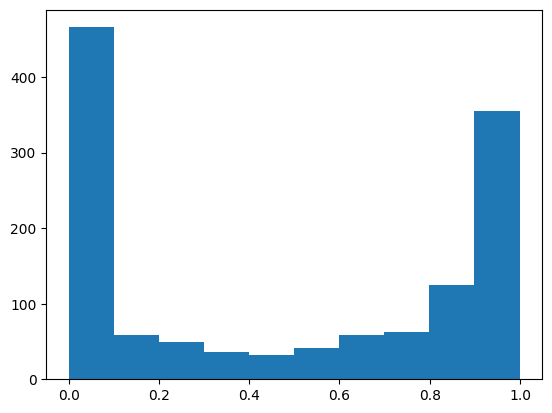

In [7]:
plt.hist(predictions)

In [11]:
model.get_submodule('module')

PreFerPredictor(
  (encoder): CustomExcelFormer(
    (embedding): SurveyEmbeddings(
      (answer_embedding): Embedding(860, 48, padding_idx=101)
      (yearly_embedding): Embedding(14, 48)
      (question_embedding): Embedding(149, 48)
      (drop_year): Dropout1d(p=0.25, inplace=False)
    )
    (embedding_norm): InstanceNorm1d(149, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (excelformer_convs): ModuleList(
      (0-4): 5 x ExcelFormerConv(
        (norm_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (DiaM): DiaM(
          (lin_q): Linear(in_features=48, out_features=48, bias=True)
          (lin_k): Linear(in_features=48, out_features=48, bias=True)
          (lin_v): Linear(in_features=48, out_features=48, bias=True)
          (lin_out): Linear(in_features=48, out_features=48, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm_2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (AiuM): Aiu